In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
from src.resnet.utils.import_csv import import_csv, split_data


data = import_csv()
train_data, val_data = split_data(data=data)

In [6]:
len(train_data)

860

In [7]:
from src.resnet.dataloader.mygo_dataloader import dataset_transform, data_loader
train_data_transformed = dataset_transform(data=train_data, mode="train")
val_data_transformed = dataset_transform(data=val_data, mode="val")
train_loader = data_loader(tranformed_dataset=train_data_transformed, batch_size=16, num_workers=1, shuffle=True)
val_loader = data_loader(tranformed_dataset=val_data_transformed, batch_size=16, num_workers=1, shuffle=True)

In [8]:
len(train_loader)



54

In [9]:
len(val_loader)

14

In [10]:
import matplotlib.pyplot as plt
import numpy as np
idx = 8
data, labels = next(iter(val_loader))
print(len(labels), len(data))
print(data.shape)
image_np = data[idx].numpy().transpose((1,2,0))
image_np = image_np * 0.229 + 0.485  # Undo normalization (normalize values back to the original range)

# If the image looks too dark due to normalization, try scaling it
image_np = np.clip(image_np, 0, 1) 

plt.imshow(image_np)
plt.title(labels[idx])

error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\gigabyte\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gigabyte\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "d:\project\MyGoCharacterClassification\src\resnet\dataloader\dataset.py", line 20, in __getitem__
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
cv2.error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



In [8]:
labels

('0',
 '8',
 '4',
 '0',
 '1',
 '1',
 '0',
 '2',
 '5',
 '1',
 '10',
 '2',
 '3',
 '0',
 '10',
 '6')

In [9]:
type(data)

torch.Tensor

In [11]:
from src.resnet.resnet_model.mygo_model import ResNet50
import torch.nn as nn
import torch

torch.manual_seed(32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_resnet = ResNet50(input_channel=3).to(device)
from timeit import default_timer as timer

# Import tqdm for progress bar
from tqdm.auto import tqdm

def accuracy_fn(y_pred,y_true):
    # Get the predicted class by finding the index with the maximum value
    y_pred_class = torch.argmax(y_pred)
    
    # Check how many predictions are correct
    correct_predictions = torch.eq(y_pred_class, y_true).sum().item()
    
    # Calculate the accuracy
    accuracy = (correct_predictions / len(y_true)) * 100
    
    return accuracy

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(params=model_resnet.parameters(),
                            lr=0.01)

C:\Users\gigabyte\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
epochs = 10
all_labels = []
all_preds = []
time_start = timer()
for epoch in tqdm(range(epochs)):
    print(f"Epoch = {epoch+1}\n-------------")
    train_loss = 0
    train_acc = 0
    model_resnet.train()
    for batch, (X, y) in enumerate(train_loader):
        X = X.to(device)          
        y = torch.tensor([int(label) for label in y], dtype=torch.long, device=device)
        y_logits = model_resnet(X)
        y_logits = y_logits - torch.max(y_logits).item()
        y_pred = torch.argmax(y_logits,dim=1)
        #calculate loss and costfunction
        acc = accuracy_fn(y_pred=y_pred,y_true=y)
        loss = loss_fn(y_logits,y)
        train_loss += loss.item()
        train_acc += acc

        #grad to zero
        optimizer.zero_grad()

        #backpropagation
        loss.backward()

        #gradient descent
        optimizer.step()
        if(batch%20 == 0):
            print(f"loss: {loss.item():.5f} ,ACC: {acc:.2f}\n")
    train_loss = train_loss/len(train_loader)
    train_acc = train_acc/len(train_loader)

    #val dataset
    val_loss = 0
    val_acc = 0
    for batch, (X_val_batch, y_val) in enumerate(val_loader):
        X_val_batch = X_val_batch.to(device)
        y_val = torch.tensor([int(label) for label in y_val], dtype=torch.long, device=device)
        model_resnet.eval()
        with torch.inference_mode():
            y_val_logits = model_resnet(X_val_batch)
            y_val_logits = y_val_logits - torch.max(y_val_logits).item()
            y_val_pred = torch.argmax(y_val_logits,dim=1)
            loss = loss_fn(y_val_logits,y_val)
            acc = accuracy_fn(y_val_pred,y_val)
            val_loss += loss.item()
            val_acc += acc
    val_loss /=len(val_loader)
    val_acc /=len(val_loader)
    
    print(f"Train loss: {train_loss:.5f} ,Train acc: {train_acc:.2f}\n Val loss: {val_loss:.5f}, Val acc: {val_acc:.2f}\n")
time_end = timer()
duration = time_end-time_start
print(f"time use:{(duration):2f}seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch = 1
-------------


  0%|          | 0/10 [00:11<?, ?it/s]


error: Caught error in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "C:\Users\gigabyte\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\_utils\worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\gigabyte\AppData\Roaming\Python\Python312\site-packages\torch\utils\data\_utils\fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "d:\project\MyGoCharacterClassification\src\resnet\dataloader\dataset.py", line 20, in __getitem__
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
cv2.error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'



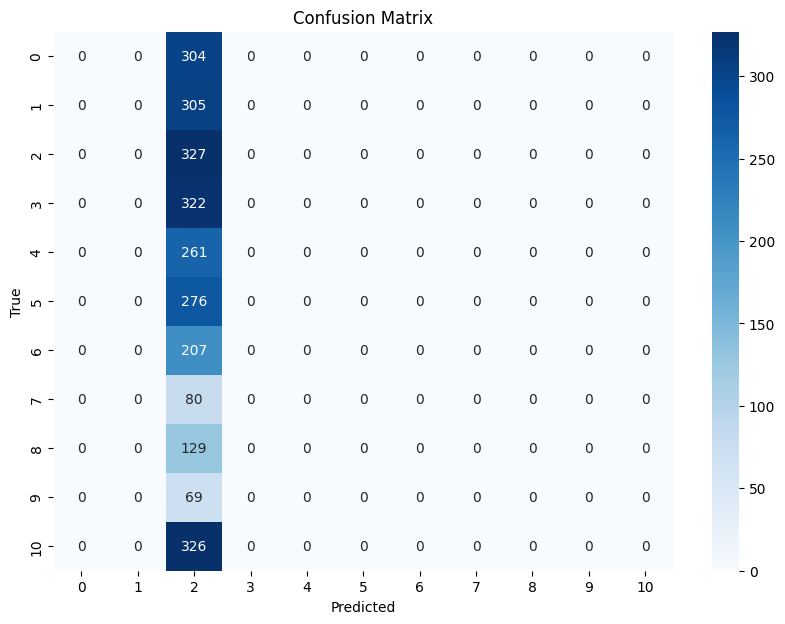

In [17]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Lists to store all true labels and predictions
all_labels = []
all_preds = []

# Iterate over the batches
for batch, (X, y) in enumerate(train_loader):
    X = X.to(device)
    y = torch.tensor([int(label) for label in y], dtype=torch.long, device=device)
    
    # Get predictions
    with torch.no_grad():
        y_pred = model_resnet(X).squeeze()
    # Convert predictions to class labels (e.g., using argmax for multi-class classification)
    y_pred_labels = torch.argmax(y_pred, dim=1)

    # Accumulate the true labels and predicted labels
    all_labels.extend(y.cpu().numpy())
    all_preds.extend(y_pred_labels.cpu().numpy())

# Calculate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(cm.shape[0]), yticklabels=range(cm.shape[0]))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [14]:
y_pred

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')